In [1]:
import numpy as np
import pandas as pd
import os
import zipfile
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import torch
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default='notebook'

Загрузка датасета и распаковка:


In [ ]:
!wget https://github.com/observethesun/sunspot_groups/raw/main/dataset/sunspot_dataset.zip
!unzip sunspot_dataset.zip

Клонируем репозиторий:

In [3]:
!git clone https://github.com/observethesun/helio.git

Cloning into 'helio'...
remote: Enumerating objects: 769, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 769 (delta 80), reused 127 (delta 69), pack-reused 607
Receiving objects: 100% (769/769), 6.80 MiB | 16.58 MiB/s, done.
Resolving deltas: 100% (405/405), done.


Устанавливаем пакеты из файла requirements.txt:

In [ ]:
%cd /content/helio
!pip install -r requirements.txt

Импортируем необходимы модули из библиотеки `helio` и определяем устройство на котором будет выполняться код:

In [5]:
from helio import FilesIndex, HelioBatch, BatchSampler
from helio import VAE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cuda')

Определяем модель вариационного автоэнкодера с использованием класса VAE из библиотеки helio. Модель VAE имеет входной канал 1, а уровни кодера и декодера имеют размеры фильтров [16, 24, 32, 64] и [48, 32, 24, 16] соответственно. Размерность скрытого пространства установлена равной 16. Выходной слой декодера имеет канал «c» и размер фильтра 1. Модель использует нормализацию.

In [7]:
net = VAE(in_channels=1,
    filters_enc=[16, 24, 32, 64],
    filters_dec=[48, 32, 24, 16],
    z_dim=16,
    output=dict(layout='c', filters=1),
    norm=True,
    variational=True).to(device)

Для расчета потерь восприятия нам также понадобится предварительно обученная модель VGG11. Следуя рекомендациям к модели VGG11, определяем тензоры среднего и стандартного отклонения.

In [8]:
vgg = models.vgg11(pretrained=True)
dis = vgg.features.to(device)
vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:05<00:00, 92.9MB/s]


Индексируем файлы в наборе данных изображений группы солнечных пятен и сортируем:

In [9]:
itrain = FilesIndex(path='/content/sunspot_dataset/*.npz', name='img').sort_index()

Настраиваем оптимизатор:

In [10]:
optimizer_ae = optim.Adam(net.parameters(), lr=0.001)

Определяем функцию, измеряющую расхождение Кульбака-Лейблера.  
Определяем batch sampler.  
Определяем функцию для преобразования 3-канальных бинарных масок в одноканальное изображение.

In [11]:
def loss_kl(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

sampler = BatchSampler(itrain, n_epochs=10, batch_size=32,
                       shuffle=True, drop_incomplete=True)
def transform_channels(arr):
    out = (arr[..., 0] | arr[..., 2]).astype(np.float32)
    out[arr[..., 1]] = 2
    return np.expand_dims(out, 0) / 2 #normalize to [0, 1]

Производим обучение модели VAE. Вычисляем:

*   потери при восстановлении (loss1) с использованием пиксельной (MSE),
*   потери восприятие (loss2) с помощью модели дискриминатора (dis),
*   потери Кульбака-Лейблера (loss3)
*   итоговые потери (loss)
Производим оптимизацию.


In [ ]:
net = net.train()
dis = dis.eval()

loss_hist = []
t = tqdm(sampler)

for ids in t:
    #Load data
    batch = (HelioBatch(ids)
             .load('img', sparse=True)
             .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
             .apply(transform_channels, src='img'))

    #Convert arrays to torch tensors
    x = torch.tensor(np.stack(batch.img)).to(device)

    #Run the VAE model
    out, mu, logvar = net(x)

    #Reconstruction loss (pixel-wise MSE)
    loss1 = ((x - out)**2).mean()

    #Data preparation for the perceptual loss
    x3 = torch.cat([x, x, x], dim=1)
    out3 = torch.cat([out, out, out], dim=1)

    fx = dis((x3 - vgg_mean) / vgg_std)
    fout = dis((out3 - vgg_mean) / vgg_std)

    #Perceptual loss
    loss2 = ((fx - fout)**2).mean()

    #Kullback-Leibler loss
    loss3 = loss_kl(mu, logvar)

    #Final loss
    loss = 100*loss1 + loss2 + loss3

    #loss_hist.append([loss1.item(), loss2.item(), loss3.item()])
    t.set_description("Loss rec {:.4f} dis {:.4f} kl {:.4f}"
                      .format(loss1.item(), loss2.item(), loss3.item()))

    #Make optimization step
    optimizer_ae.zero_grad()
    loss.backward()
    optimizer_ae.step()

Loss rec 0.0011 dis 0.1191 kl 0.0282: 100%|██████████| 2650/2650 [27:26<00:00,  1.61it/s]


####Код для сохранения и загрузки модели

In [12]:
# Создание директории для сохранения модели
if not os.path.exists('/content/model_dumps'):
    os.makedirs('/content/model_dumps')

In [ ]:
torch.save(net.state_dict(), '/content/model_dumps/vae')

In [13]:
net = VAE(in_channels=1,
    filters_enc=[16, 24, 32, 64],
    filters_dec=[48, 32, 24, 16],
    z_dim=16,
    output=dict(layout='c', filters=1),
    norm=True,
    variational=True).to(device)

net.load_state_dict(torch.load('/content/model_dumps/vae'))

index = FilesIndex(path='/content/sunspot_dataset/*.npz', name='img').sort_index()


itrain = index
#optimizer_ae = optim.Adam(net.parameters(), lr=0.001)

def transform_channels(arr):
    out = (arr[..., 0] | arr[..., 2]).astype(np.float32)
    out[arr[..., 1]] = 2
    return np.expand_dims(out, 0) / 2 #normalize to [0, 1]

####Получаем скрытые векторы с помощью модели VAE:

In [14]:
emb = [] #array of latent vectors
sampler = BatchSampler(itrain, n_epochs=1, batch_size=64,
                       shuffle=False, drop_incomplete=False)

net = net.eval()
with torch.no_grad():
    for ids in sampler:
        batch = (HelioBatch(ids)
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)
        y = net.encode(x)
        emb.append(y.detach().cpu().numpy().reshape(y.shape[0], -1))
emb = np.vstack(emb)

Визуализируем латентные векторы.

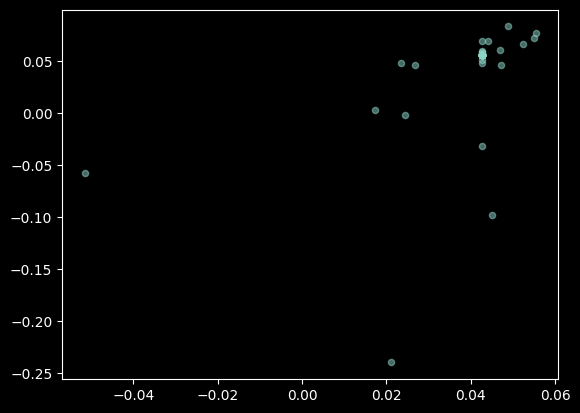

In [ ]:
plt.style.use('dark_background')
plt.scatter(emb[:, 0], emb[:, 1], s=20, alpha=0.5)
plt.show()

Можем наблюдать, что данные имеют выбросы. Удалим строки с выбросами:

In [15]:
rows_to_delete = [13, 8158, 5670, 5863, 2064, 2068, 444, 10, 7495, 4237, 4598, 6705, 2724, 11, 831, 4737,\
                  4230, 3593, 4266, 909, 370, 4712, 826, 3583, 10, 2715, 7475, 4226]
emb = np.delete(emb, rows_to_delete, axis=0)

rows_to_delete2 = [823, 2709, 7458, 4216, 3576, 4569, 6669, 4704, 4209, 821, 2704, 7439, 4554, 3569, 6651, 4199, 4688,\
                   365, 893, 4217, 4640, 6898, 894, 1108]
emb = np.delete(emb, rows_to_delete2, axis=0)

rows_to_delete3 = [6873, 6666, 5448, 1181, 6609, 4160, 1634, 1136, 2129, 4190, 2379, 2049, 2452, 359, 726, 5821, 6641,\
                   2138, 4230, 4220, 2159, 5335, 1095, 2920, 6946, 7147, 6630, 5297, 6689, 2138, 1277, 904]
emb = np.delete(emb, rows_to_delete3, axis=0)

Теперь посмотрим на данные без выбросов:

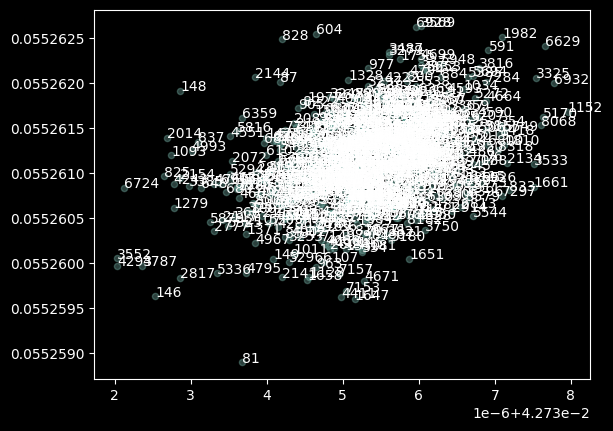

In [ ]:
plt.scatter(emb[:, 0], emb[:, 1], s=20, alpha=0.3)

for i in range(len(emb)):
    plt.annotate(str(i), (emb[i, 0], emb[i, 1]))

plt.show()

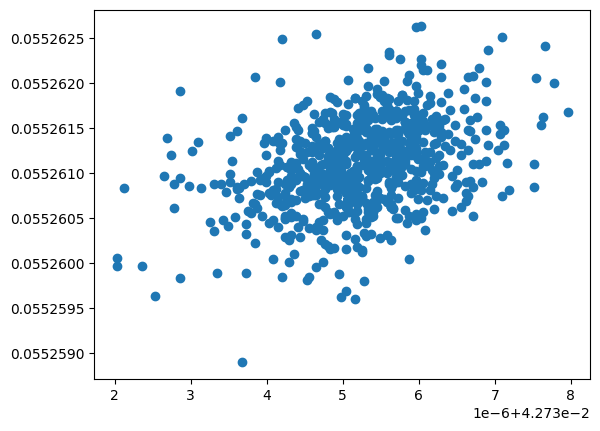

In [ ]:
plt.scatter(emb[:, 0], emb[:, 1])#, s=10, alpha=0.3)
plt.show()

#Hierarchical clustering

Выполним иерархическую кластеризацию используя алгоритм минимизации Уорда.  
Построим дендрограмму.

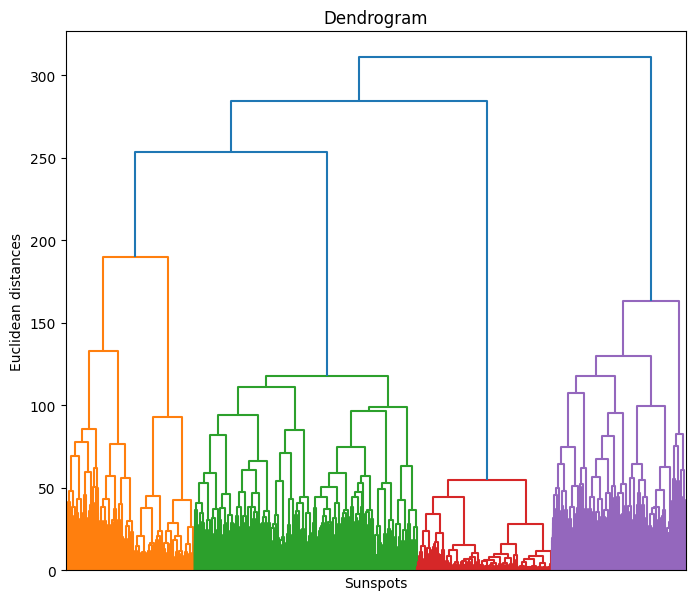

In [17]:
hier_clust = linkage(emb, method='ward')
plt.figure(figsize=(8, 7))
dendrogram(hier_clust,
            orientation='top',
            no_labels=True,
            distance_sort='descending')

plt.title('Dendrogram')
plt.xlabel('Sunspots')
plt.ylabel('Euclidean distances')
plt.show()

На основе дендрограммы разделим данные на 4 кластера:

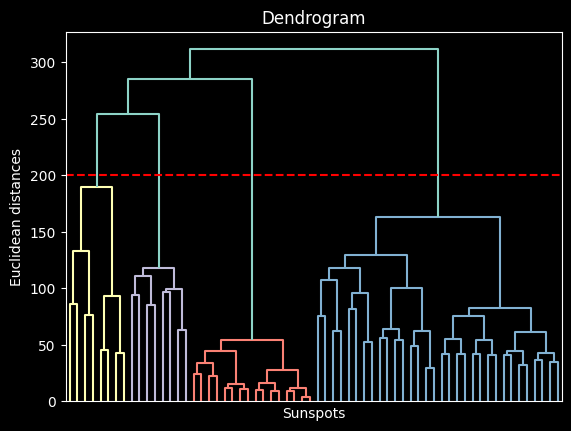

In [ ]:
dendrogram(
            hier_clust,
            truncate_mode='level',
            p=5,
            orientation='top',
            distance_sort='descending',
            no_labels=True)

plt.title('Dendrogram')
plt.xlabel('Sunspots')
plt.ylabel('Euclidean distances')
plt.axhline(y=200, color='red', linestyle='--')
plt.show()

Количество уникальных меток (кластеров):

In [18]:
# получение меток кластеров для каждого изображения
labels_1 = fcluster(hier_clust, t=250, criterion='distance')
len(set(labels_1))

4

Определим оптимальное количество кластеров с помощью метода локтя (elbow method):

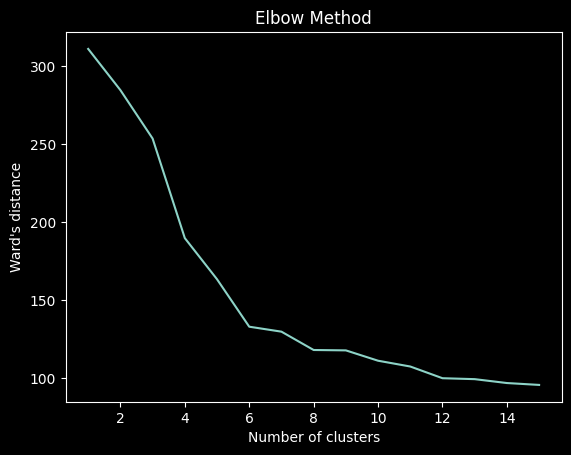

In [ ]:
# получаем список последних 15 значений расстояний между кластерами при их слиянии
distances = hier_clust[-15:, 2]

# сортируем список расстояний в порядке убывания
distances_sorted = sorted(distances, reverse=True)

#plt.figure(figsize=(10, 7))
plt.plot(range(1, len(distances_sorted) + 1), distances_sorted)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Ward's distance")
plt.show()

На основе графика можем предположить, о наличии 6 кластерных структур.

In [19]:
labels_2 = fcluster(hier_clust, t=150, criterion='distance')
len(set(labels_2))

6

#TSNE

###Визуализируем 4 кластерные структуры

В пространстве размерности 2:

In [20]:
tsne=TSNE(n_components=2, random_state=0)
emb_tsne = tsne.fit_transform(emb)

In [28]:
fig = px.scatter(
    emb_tsne, x=0, y=1,
    labels={'color': 'species'},
    color=labels_1
)
fig.update_traces(marker_size=5)
fig.show()

В пространстве размерности 3:

In [29]:
tsne=TSNE(n_components=3, random_state=0, perplexity=5)
emb_tsne = tsne.fit_transform(emb)

In [30]:
fig = go.Figure(data=[go.Scatter3d(
    x=emb_tsne[:, 0],
    y=emb_tsne[:, 1],
    z=emb_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=labels_1,
        colorscale='Viridis',
        opacity=0.8
    ),
    hovertext=['Image #' + str(i) for i in range(len(emb_tsne))],
    hoverinfo='text'
)])

fig.show()

In [31]:
tsne=TSNE(n_components=3, random_state=0, perplexity=50)
emb_tsne = tsne.fit_transform(emb)

fig = go.Figure(data=[go.Scatter3d(
    x=emb_tsne[:, 0],
    y=emb_tsne[:, 1],
    z=emb_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=labels_1,
        colorscale='Viridis',
        opacity=0.8
    ),
    hovertext=['Image #' + str(i) for i in range(len(emb_tsne))],
    hoverinfo='text'
)])

fig.show()

###Представим 6 кластерных структур

В пространстве размерности 2:

In [32]:
tsne=TSNE(n_components=2, random_state=0)
emb_tsne = tsne.fit_transform(emb)

In [34]:
fig = px.scatter(
    emb_tsne, x=0, y=1,
    labels={'color': 'species'},
    color=labels_2
)
fig.update_traces(marker_size=5)
fig.show()

В пространстве размерности 3:

In [ ]:
tsne=TSNE(n_components=3, perplexity=30, random_state=0)
emb_tsne = tsne.fit_transform(emb)

In [ ]:
fig = go.Figure(data=[go.Scatter3d(
    x=emb_tsne[:, 0],
    y=emb_tsne[:, 1],
    z=emb_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=labels_2,
        colorscale='Viridis',
        opacity=0.8
    ),
    hovertext=['Image #' + str(i) for i in range(len(emb_tsne))],
    hoverinfo='text'
)])

fig.show()

In [ ]:
tsne=TSNE(n_components=3, perplexity=40, random_state=0)
emb_tsne = tsne.fit_transform(emb)

In [ ]:
fig = go.Figure(data=[go.Scatter3d(
    x=emb_tsne[:, 0],
    y=emb_tsne[:, 1],
    z=emb_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=labels_2,
        colorscale='Viridis',
        opacity=0.8
    ),
    hovertext=['Image #' + str(i) for i in range(len(emb_tsne))],
    hoverinfo='text'
)])

fig.show()